<a href="https://colab.research.google.com/github/jihyeon602/ETRI_lifelog_dataset/blob/main/ETRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 경로지정, parquet 파일 확인

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 1. 실험 재현을 위한 Seed 고정 (가장 맨 위에 둬야 함)
import os
import random
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()  # TensorFlow 2.9 이상에서만

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from scipy.stats import mode
from scipy import stats
from datetime import timedelta
from tqdm import tqdm

# Note: Set the file path associated with the dataset.
challenge2025_dataset_path = '/content/drive/MyDrive/Sleep/ch2025_data_items'

# To print the list of data items
print("challenge 2025 dataset " + "="*5,'\n')
for file_name in sorted(os.listdir(challenge2025_dataset_path)):
    if file_name.endswith('.parquet'):
        print(file_name)

challenge 2025 dataset ===== 

ch2025_mACStatus.parquet
ch2025_mActivity.parquet
ch2025_mAmbience.parquet
ch2025_mBle.parquet
ch2025_mGps.parquet
ch2025_mLight.parquet
ch2025_mScreenStatus.parquet
ch2025_mUsageStats.parquet
ch2025_mWifi.parquet
ch2025_wHr.parquet
ch2025_wLight.parquet
ch2025_wPedo.parquet


# 데이터 전처리

### 1. mACStatus, 1분당 1회

In [5]:
data_item = "mACStatus"  # 스마트폰 충전 여부
input1 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

### 2. mActivity,  1분당 1회

In [6]:
data_item = "mActivity" # 사용자 활동 상태
input2 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 원-핫 인코딩 수행
activity_ohe = pd.get_dummies(input2['m_activity'], prefix='activity').astype(int)

# 기존 데이터와 결합 (subject_id, timestamp 유지)
input2 = pd.concat([input2[['subject_id', 'timestamp']], activity_ohe], axis=1)

### 3. mAmbience, 2분당 1회

In [7]:
data_item = "mAmbience"  # 주변 소음 데이터
input3 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# timestamp 초단위 제거 (초를 0초로)
input3['timestamp'] = input3['timestamp'].dt.floor('min')

# 전체 key 수집
all_keys = set()
for row in input3['m_ambience']:
    for item in row:
        all_keys.add(item[0])

key_list = sorted(all_keys)
key_to_index = {key: idx for idx, key in enumerate(key_list)}
vector_length = len(key_list)

# key-value → 확률 벡터 변환 함수
def ambience_to_vector(row):
    vec = np.zeros(vector_length, dtype=np.float32)
    for item in row:
        key, value = item
        if key in key_to_index:
            vec[key_to_index[key]] = float(value)
    return vec

# 변환 적용
ambience_vectors = np.stack(input3['m_ambience'].apply(ambience_to_vector))
ambience_df = pd.DataFrame(ambience_vectors, columns=[f"amb_{k}" for k in key_list], index=input3.index)

# PCA 적용
amb_data = ambience_df.values
pca = PCA(n_components=10, random_state=42)
amb_pca = pca.fit_transform(amb_data)
pca_cols = [f'amb_pca_{i}' for i in range(1, 11)]
amb_pca_df = pd.DataFrame(amb_pca, columns=pca_cols, index=input3.index)

# subject_id, timestamp와 결합
input3 = pd.concat([input3[['subject_id', 'timestamp']], amb_pca_df], axis=1)

### 4. mBLE, 10분당 1회

In [8]:
# Step 0: Load parquet
data_item = "mBle"
input4 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# Step 1: m_ble explode + 정리
exploded = input4.explode('m_ble').reset_index(drop=True)
ble_df = pd.json_normalize(exploded['m_ble'])

# Step 2: subject_id, timestamp 복원
ble_df['subject_id'] = exploded['subject_id']
ble_df['timestamp'] = exploded['timestamp']

# Step 3: RSSI 수치 정제 및 통계 요약
ble_df['rssi'] = ble_df['rssi'].astype(float)
ble_stats = ble_df.groupby(['subject_id', 'timestamp'])['rssi'].agg(
    ble_rssi_mean='mean',
    ble_rssi_std='std',
    ble_rssi_min='min',
    ble_rssi_max='max',
    ble_rssi_count='count'
).reset_index()

# Step 4: device_class One-hot 인코딩 + 평균 집계
device_ohe = pd.get_dummies(ble_df['device_class'], prefix='ble_device_class').astype(int)
ble_df = pd.concat([ble_df, device_ohe], axis=1)
device_class_agg = ble_df.groupby(['subject_id', 'timestamp'])[device_ohe.columns].mean().reset_index()

# Step 5: address 고유 개수 count
address_count = ble_df.groupby(['subject_id', 'timestamp'])['address'].nunique().reset_index()
address_count = address_count.rename(columns={'address': 'ble_device_unique_count'})

# Step 6: 병합
input4_cnn = ble_stats.merge(device_class_agg, on=['subject_id', 'timestamp'], how='outer')
input4_cnn = input4_cnn.merge(address_count, on=['subject_id', 'timestamp'], how='outer')
input4_cnn = input4_cnn.fillna(0)

# Step 7: RSSI 통계 정규화 (z-score)
rssi_cols = ['ble_rssi_mean', 'ble_rssi_std', 'ble_rssi_min', 'ble_rssi_max', 'ble_rssi_count']
scaler = StandardScaler()
input4_cnn[rssi_cols] = scaler.fit_transform(input4_cnn[rssi_cols])

# Step 8: device_class OHE → PCA(5차원 축소)
device_ohe_cols = [col for col in input4_cnn.columns if col.startswith('ble_device_class_')]
device_ohe_data = input4_cnn[device_ohe_cols]

pca = PCA(n_components=5, random_state=42)
device_pca = pca.fit_transform(device_ohe_data)
pca_cols = [f'ble_device_pca_{i+1}' for i in range(5)]
device_pca_df = pd.DataFrame(device_pca, columns=pca_cols, index=input4_cnn.index)

# Step 9: PCA 결과 붙이기 + 기존 OHE 제거
input4_cnn = pd.concat([input4_cnn.drop(columns=device_ohe_cols), device_pca_df], axis=1)

# Step 10: ble_device_unique_count 정규화 (0~1 스케일)
scaler = StandardScaler()
input4_cnn['ble_device_unique_count'] = scaler.fit_transform(input4_cnn[['ble_device_unique_count']])
input4 = input4_cnn

### 5. mGps

In [9]:
data_item = "mGps"  # 스마트폰으로 측정된 GPS 데이터, 위치 데이터
input5 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# Step 1: m_gps 속도 평균 계산
def compute_speed_mean(mgps_list):
    if not isinstance(mgps_list, (list, np.ndarray)) or len(mgps_list) == 0:
        return np.nan
    speeds = [point.get('speed', 0) for point in mgps_list if isinstance(point, dict) and 'speed' in point]
    if not speeds:
        return np.nan
    return np.mean(speeds)

input5['speed_mean'] = input5['m_gps'].apply(compute_speed_mean)

# Step 2: m_gps 열 삭제 + NaN 제거
input5 = input5[['subject_id', 'timestamp', 'speed_mean']]
input5 = input5.dropna(subset=['speed_mean'])

# Step 3: speed_mean 클리핑 (10m/s 초과 값 10으로 고정)
input5['speed_mean'] = input5['speed_mean'].clip(upper=10)

# Step 4: speed_mean에 Z-Score 정규화 적용
scaler = StandardScaler()
input5['speed_zscore'] = scaler.fit_transform(input5[['speed_mean']])

### 6. mLight, 10분당 1회

In [10]:
data_item = "mLight"  # 주변 밝기 수준 (Lux)
input6 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# Step 1: 로그 변환
input6['m_light_log'] = np.log1p(input6['m_light'])

# Step 2: Z-Score 정규화
scaler = StandardScaler()
input6['m_light_zscore'] = scaler.fit_transform(input6[['m_light_log']])

# Step 3: 최종 CNN 입력용 컬럼 정리
input6 = input6[['subject_id', 'timestamp', 'm_light_zscore']]

### 7. mScreenStatus, 1분당 1회

In [11]:
data_item = "mScreenStatus"  # 스마트폰 화면 켜짐 여부
input7 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# One-Hot Encoding
screen_ohe = pd.get_dummies(input7['m_screen_use'], prefix='screen').astype(int)

# 최종 정제: m_screen_use도 남기고 OHE도 추가
input7 = pd.concat([input7[['subject_id', 'timestamp']], screen_ohe], axis=1)

### 8. mUsageStats, 10분당 1회

In [12]:
data_item = "mUsageStats" # 10분간 어플 사용정보
input8 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 어플사용시간 비율/10분
def calc_usage_ratio(app_list):
    if not isinstance(app_list, (list, np.ndarray)) or len(app_list) == 0:
        return np.nan
    total_time = sum(item.get('total_time', 0) for item in app_list)
    return (total_time/600000) / len(app_list)
input8['usage_ratio'] = input8['m_usage_stats'].apply(calc_usage_ratio)

# 편향되어있어서 Min-Max 정규화
# Min-Max 정규화
min_val = input8['usage_ratio'].min()
max_val = input8['usage_ratio'].max()
input8['usage_ratio_norm'] = (input8['usage_ratio'] - min_val) / (max_val - min_val)
input8 = input8.drop(columns=['m_usage_stats','usage_ratio'])

### 9. mWifi, 10분당 1회

In [13]:
data_item = "mWifi"
input9 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# Step 1: m_wifi explode + 정리
exploded = input9.explode('m_wifi').reset_index(drop=True)
wifi_df = pd.json_normalize(exploded['m_wifi'])

# Step 2: subject_id, timestamp 복원
wifi_df['subject_id'] = exploded['subject_id']
wifi_df['timestamp'] = exploded['timestamp']

# Step 3: RSSI 수치 정제 및 통계 요약
wifi_df['rssi'] = wifi_df['rssi'].astype(float)
wifi_stats = wifi_df.groupby(['subject_id', 'timestamp'])['rssi'].agg(
    wifi_rssi_mean='mean',
    wifi_rssi_std='std',
    wifi_rssi_min='min',
    wifi_rssi_max='max',
    wifi_rssi_count='count'
).reset_index()

# Step 4: 상위 100개 BSSID만 One-hot 인코딩 + 평균 집계
top_bssid = wifi_df['bssid'].value_counts().sort_index().head(100).index
wifi_df['bssid_top'] = wifi_df['bssid'].where(wifi_df['bssid'].isin(top_bssid), 'OTHER')

bssid_ohe = pd.get_dummies(wifi_df['bssid_top'], prefix='bssid').astype(int)
wifi_df = pd.concat([wifi_df, bssid_ohe], axis=1)
bssid_agg = wifi_df.groupby(['subject_id', 'timestamp'])[bssid_ohe.columns].mean().reset_index()

# Step 5: 고유 BSSID 개수 count
bssid_count = wifi_df.groupby(['subject_id', 'timestamp'])['bssid'].nunique().reset_index()
bssid_count = bssid_count.rename(columns={'bssid': 'bssid_count'})

# Step 6: 병합
input9_cnn = wifi_stats.merge(bssid_agg, on=['subject_id', 'timestamp'], how='outer')
input9_cnn = input9_cnn.merge(bssid_count, on=['subject_id', 'timestamp'], how='outer')
input9_cnn = input9_cnn.fillna(0)

# Step 7: RSSI 관련 통계 정규화 (z-score)
rssi_cols = ['wifi_rssi_mean', 'wifi_rssi_std', 'wifi_rssi_min', 'wifi_rssi_max', 'wifi_rssi_count']
scaler = StandardScaler()
input9_cnn[rssi_cols] = scaler.fit_transform(input9_cnn[rssi_cols])

# Step 8: bssid 컬럼 이름 정리 → bssid_1 ~ bssid_100, bssid_OTHER
bssid_cols = [col for col in input9_cnn.columns if col.startswith('bssid_')]
other_col = [col for col in bssid_cols if col.endswith('OTHER')]
top_cols = sorted(set(bssid_cols) - set(other_col))

rename_map = {col: f"bssid_{i+1}" for i, col in enumerate(top_cols)}
if other_col:
    rename_map[other_col[0]] = 'bssid_OTHER'

input9_cnn = input9_cnn.rename(columns=rename_map)

# Step 9: PCA 적용 대상 컬럼 찾기
pca_input_cols = [col for col in input9_cnn.columns if col.startswith('bssid_')]

# Step 10: PCA 적용 (예: 10차원으로 축소)
pca = PCA(n_components=10, random_state=42)
bssid_pca = pca.fit_transform(input9_cnn[pca_input_cols])
pca_cols = [f'bssid_pca_{i+1}' for i in range(10)]
bssid_pca_df = pd.DataFrame(bssid_pca, columns=pca_cols, index=input9_cnn.index)

# Step 11: PCA 결과 붙이기 + 기존 OHE 제거
input9 = pd.concat([input9_cnn.drop(columns=pca_input_cols), bssid_pca_df], axis=1)

### 10. wHr

In [14]:
# Step 1: 심박수 데이터 로드
data_item = "wHr"  # 심박수
input10 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# Step 2: 심박수 통계 계산 함수 (이상치 필터링 포함)
def calc_hr_stats_filtered(hr_list):
    if not isinstance(hr_list, (list, np.ndarray)) or len(hr_list) == 0:
        return pd.Series([np.nan] * 5)
    valid = [x for x in hr_list if 40 <= x <= 200]
    if len(valid) == 0:
        return pd.Series([np.nan] * 5)
    min_hr = np.min(valid)
    mean_hr = np.mean(valid)
    median_hr = np.median(valid)
    mode_result = stats.mode(valid, keepdims=True)
    mode_hr = mode_result.mode[0] if mode_result.count[0] > 0 else np.nan
    max_hr = np.max(valid)
    return pd.Series([min_hr, mean_hr, median_hr, mode_hr, max_hr])

# Step 3: 통계 컬럼 생성
input10[['min_hr', 'mean_hr', 'median_hr', 'mode_hr', 'max_hr']] = input10['heart_rate'].apply(calc_hr_stats_filtered)

# Step 4: NaN 제거
input10 = input10.dropna(subset=['mean_hr'])

# Step 5: heart_rate 컬럼 제거
input10 = input10.drop(columns='heart_rate')

# Step 6: Z-Score 정규화
hr_cols = ['min_hr', 'mean_hr', 'median_hr', 'mode_hr', 'max_hr']
scaler = StandardScaler()
input10_zscore = scaler.fit_transform(input10[hr_cols])

# Step 7: 정규화된 결과를 DataFrame에 넣기
input10_zscore = pd.DataFrame(input10_zscore, columns=[f'{col}_zscore' for col in hr_cols], index=input10.index)

# Step 8: 원본 min/mean/median/mode/max 컬럼 삭제 후 zscore 컬럼 붙이기
input10 = pd.concat([input10[['subject_id', 'timestamp']], input10_zscore], axis=1)

### 11. wLight, 1분당 1회

In [15]:
data_item = "wLight"
input11 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# Step 1: 로그 변환
input11['w_light_log'] = np.log1p(input11['w_light'])

# Step 2: Z-Score 정규화
scaler = StandardScaler()
input11['w_light_zscore'] = scaler.fit_transform(input11[['w_light_log']])

# Step 3: 최종 CNN 입력용 컬럼만 유지
input11_cnn = input11[['subject_id', 'timestamp', 'w_light_zscore']]
input11 = input11_cnn

### 12. wPedo, 1분당 1회

In [16]:
data_item = "wPedo"
input12 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 빈 열, 이상치 제거
input12 = input12.drop(columns=['running_step', 'walking_step'])
input12 = input12[input12['burned_calories'] <= 15]

# 정규화
features_to_norm = ['step', 'step_frequency', 'distance', 'speed', 'burned_calories']
# log1p 적용
for col in features_to_norm:
    input12[f'{col}_log'] = np.log1p(input12[col])
# Min-Max 정규화
for col in features_to_norm:
    log_col = f'{col}_log'
    min_val = input12[log_col].min()
    max_val = input12[log_col].max()
    input12[f'{col}_norm'] = (input12[log_col] - min_val) / (max_val - min_val)

input12_cnn = input12[['subject_id', 'timestamp'] + [f'{col}_norm' for col in features_to_norm]]
input12 = input12_cnn

In [18]:
input12

,subject_id,timestamp,step_norm,step_frequency_norm,distance_norm,speed_norm,burned_calories_norm
0,id01,2024-06-26 12:09:00,0.416153,0.083873,0.3908,0.072306,0.0
1,id01,2024-06-26 12:10:00,0.000000,0.000000,0.0000,0.000000,0.0
2,id01,2024-06-26 12:11:00,0.000000,0.000000,0.0000,0.000000,0.0
3,id01,2024-06-26 12:12:00,0.000000,0.000000,0.0000,0.000000,0.0
4,id01,2024-06-26 12:13:00,0.000000,0.000000,0.0000,0.000000,0.0
...,...,...,...,...,...,...,...
748095,id10,2024-09-26 23:55:00,0.000000,0.000000,0.0000,0.000000,0.0
748096,id10,2024-09-26 23:56:00,0.000000,0.000000,0.0000,0.000000,0.0
748097,id10,2024-09-26 23:57:00,0.000000,0.000000,0.0000,0.000000,0.0
748098,id10,2024-09-26 23:58:00,0.000000,0.000000,0.0000,0.000000,0.0


# Train.csv, Input Data 구조 설정

In [19]:
# 레이블 로딩
df_label = pd.read_csv("/content/drive/MyDrive/Sleep/ch2025_metrics_train.csv")
df_label['lifelog_date'] = pd.to_datetime(df_label['lifelog_date'])
df_label['sleep_date'] = pd.to_datetime(df_label['sleep_date'])

# feature 구조 정의 (21개 피처)
feature_structure = {
    'input1': ['m_charging'],
    'input2': ['activity_0','activity_1','activity_3','activity_4','activity_7','activity_8'],
    'input3': ['amb_pca_1','amb_pca_2','amb_pca_3','amb_pca_4','amb_pca_5','amb_pca_6','amb_pca_7','amb_pca_8','amb_pca_9','amb_pca_10'],

    'input4': ['ble_rssi_mean','ble_rssi_std','ble_rssi_min','ble_rssi_max','ble_rssi_count','ble_device_unique_count',
               'ble_device_pca_1','ble_device_pca_2','ble_device_pca_3','ble_device_pca_4','ble_device_pca_5'],
    'input5': ['speed_mean','speed_zscore'],
    'input6': ['m_light_zscore'],

    'input7': ['screen_0','screen_1'],
    'input8': ['usage_ratio_norm'],
    'input9': ['wifi_rssi_mean','wifi_rssi_std','wifi_rssi_min','wifi_rssi_max','wifi_rssi_count',
               'bssid_pca_1','bssid_pca_2','bssid_pca_3','bssid_pca_4','bssid_pca_5',
               'bssid_pca_6','bssid_pca_7','bssid_pca_8','bssid_pca_9','bssid_pca_10'],

    'input10': ['min_hr_zscore','mean_hr_zscore','median_hr_zscore','mode_hr_zscore','max_hr_zscore'],
    'input11': ['w_light_zscore'],
    'input12': ['step_norm','step_frequency_norm','distance_norm','speed_norm','burned_calories_norm']
}

# 병합 함수 정의
def merge_input_timeseries(subject_id, lifelog_date, sleep_date, input_dict):
    start = pd.to_datetime(lifelog_date) + timedelta(hours=12)
    end = pd.to_datetime(sleep_date) + timedelta(hours=12)
    base_time = pd.date_range(start=start, end=end, freq='1min')[:-1]

    df_base = pd.DataFrame({'timestamp': base_time})
    merged = df_base.copy()

    for input_name, columns in feature_structure.items():
        df = input_dict[input_name]
        df = df[df['subject_id'] == subject_id].copy()
        df = df.sort_values('timestamp').set_index('timestamp')
        df = df[~df.index.duplicated(keep='last')]
        df = df.reindex(base_time)
        df = df.ffill().bfill().infer_objects().reset_index()  # 앞뒤 모두 보간

        for col in columns:
            merged[col] = df[col]

    merged.drop(columns=['timestamp'], inplace=True)
    return merged.fillna(0)

# dict 구조로 안전하게 전달
input_dict = {
    'input1': input1, 'input2': input2, 'input3': input3,
    'input4': input4, 'input5': input5, 'input6': input6,
    'input7': input7, 'input8': input8, 'input9': input9,
    'input10': input10, 'input11': input11, 'input12': input12
}

# Input 데이터 생성

In [ ]:
# 시계열 생성
X_seq = []
for _, row in tqdm(df_label.iterrows(), total=len(df_label)):
    x = merge_input_timeseries(row['subject_id'], row['lifelog_date'], row['sleep_date'], input_dict)
    X_seq.append(x.values)

X_seq = np.stack(X_seq)
y_target = df_label[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].values

In [27]:
print(X_seq.shape)
print(y_target.shape)

(450, 1440, 60)
(450, 6)


# Model Compile 모델 구성

In [ ]:
def build_improved_cnn_model(X_seq):
    input_shape = (X_seq.shape[1], X_seq.shape[2])  # 1440, feature 수 자동 추출
    inp = Input(shape=input_shape)

    # Conv Block 1
    x = layers.Conv1D(64, kernel_size=5, strides=2, padding='same')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Conv Block 2
    x = layers.Conv1D(128, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Conv Block 3
    x = layers.Conv1D(256, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Conv Block 4
    x = layers.Conv1D(512, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling1D()(x)

    # Dense block
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    # Outputs
    out_q1 = layers.Dense(1, activation='sigmoid', name='Q1')(x)
    out_q2 = layers.Dense(1, activation='sigmoid', name='Q2')(x)
    out_q3 = layers.Dense(1, activation='sigmoid', name='Q3')(x)
    out_s1 = layers.Dense(3, activation='softmax', name='S1')(x)
    out_s2 = layers.Dense(1, activation='sigmoid', name='S2')(x)
    out_s3 = layers.Dense(1, activation='sigmoid', name='S3')(x)

    model = models.Model(inputs=inp, outputs=[out_q1, out_q2, out_q3, out_s1, out_s2, out_s3])
    return model

model = build_improved_cnn_model(X_seq)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

model.compile(
    optimizer=Adam(learning_rate=0.0005),  # learning rate ↓
    loss={
        'Q1': 'binary_crossentropy',
        'Q2': 'binary_crossentropy',
        'Q3': 'binary_crossentropy',
        'S1': 'sparse_categorical_crossentropy',
        'S2': 'binary_crossentropy',
        'S3': 'binary_crossentropy',
    },
    metrics=['accuracy']
)

2025-04-26 18:11:11.238841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-26 18:11:11.253254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-26 18:11:11.253417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-26 18:11:11.255873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-26 18:11:11.255999: I tensorflow/compile

# Model Fit, 모델학습

In [ ]:
# 데이터 분할 (명시적으로)
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_target, test_size=0.2, random_state=42)

# 모델 학습습
history = model.fit(
    X_train, {
        'Q1': y_train[:, 0],
        'Q2': y_train[:, 1],
        'Q3': y_train[:, 2],
        'S1': y_train[:, 3],
        'S2': y_train[:, 4],
        'S3': y_train[:, 5]
    },
    validation_data=(X_val, {
        'Q1': y_val[:, 0],
        'Q2': y_val[:, 1],
        'Q3': y_val[:, 2],
        'S1': y_val[:, 3],
        'S2': y_val[:, 4],
        'S3': y_val[:, 5]
    }),
    epochs=100,
    batch_size=32,
    shuffle=False,
    callbacks=[early_stop]
)

Epoch 1/100


2025-04-26 18:11:13.570752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-04-26 18:11:13.759792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-04-26 18:11:13.835423: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa25c00e020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-26 18:11:13.835457: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-04-26 18:11:13.865336: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-26 18:11:14.067556: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

12/12 [==============================] - 4s 54ms/step - loss: 4.6047 - Q1_loss: 0.6859 - Q2_loss: 0.6963 - Q3_loss: 0.6975 - S1_loss: 1.1655 - S2_loss: 0.6682 - S3_loss: 0.6913 - Q1_accuracy: 0.5556 - Q2_accuracy: 0.5639 - Q3_accuracy: 0.5250 - S1_accuracy: 0.4194 - S2_accuracy: 0.5861 - S3_accuracy: 0.5778 - val_loss: 4.4560 - val_Q1_loss: 0.6814 - val_Q2_loss: 0.6924 - val_Q3_loss: 0.6743 - val_S1_loss: 1.0558 - val_S2_loss: 0.6727 - val_S3_loss: 0.6794 - val_Q1_accuracy: 0.6111 - val_Q2_accuracy: 0.5444 - val_Q3_accuracy: 0.5778 - val_S1_accuracy: 0.4667 - val_S2_accuracy: 0.6222 - val_S3_accuracy: 0.6556
Epoch 2/100
12/12 [==============================] - 0s 22ms/step - loss: 4.2003 - Q1_loss: 0.6496 - Q2_loss: 0.6822 - Q3_loss: 0.6461 - S1_loss: 0.9902 - S2_loss: 0.6323 - S3_loss: 0.5999 - Q1_accuracy: 0.6111 - Q2_accuracy: 0.6028 - Q3_accuracy: 0.6250 - S1_accuracy: 0.5083 - S2_accuracy: 0.6778 - S3_accuracy: 0.6833 - val_loss: 4.4982 - val_Q1_loss: 0.6856 - val_Q2_loss: 0.6892 

# Model Prediction, 모델 예측 평가

In [ ]:
# 예측 및 F1 평가
y_pred = model.predict(X_seq)
binary_indices = [0, 1, 2, 4, 5]
y_pred_binary = [(y_pred[i] > 0.5).astype(int).reshape(-1) for i in binary_indices]
y_true_binary = [y_target[:, i] for i in binary_indices]
y_pred_multiclass = np.argmax(y_pred[3], axis=1)
y_true_multiclass = y_target[:, 3]
f1s = [f1_score(y_true_binary[i], y_pred_binary[i], average='macro') for i in range(5)]
f1s.append(f1_score(y_true_multiclass, y_pred_multiclass, average='macro'))
macro_f1_total = np.mean(f1s)

print("📊 Macro F1 Score (전체 평균):", round(macro_f1_total, 5))

15/15 [==============================] - 0s 5ms/step
📊 Macro F1 Score (전체 평균): 0.63904


# Submission csv 파일 생성

In [ ]:

'''
df_label = pd.read_csv("/content/drive/MyDrive/Sleep/ch2025_submission_sample.csv")

# 시계열 입력 생성
X_seq = []
for _, row in tqdm(df_label.iterrows(), total=len(df_label)):
    x = x = merge_input_timeseries(row['subject_id'], row['lifelog_date'], row['sleep_date'], input_dict)
    X_seq.append(x.values)

X_seq = np.stack(X_seq)  # shape = (N, 1440, 21)
y_target = df_label[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].values

# 예측
y_pred = model.predict(X_seq)

# 이진 분류 결과
binary_indices = [0, 1, 2, 4, 5]
y_pred_binary = [(y_pred[i] > 0.5).astype(int).reshape(-1) for i in binary_indices]
y_true_binary = [y_target[:, i] for i in binary_indices]

# 다중 분류 (S1)
y_pred_multiclass = np.argmax(y_pred[3], axis=1)
y_true_multiclass = y_target[:, 3]

# 이진 분류: Q1, Q2, Q3, S2, S3
binary_indices = [0, 1, 2, 4, 5]
y_pred_binary = [(y_pred[i] > 0.5).astype(int).reshape(-1) for i in binary_indices]

# 다중 분류: S1
y_pred_multiclass = np.argmax(y_pred[3], axis=1)

submission_sample = pd.read_csv("/content/drive/MyDrive/Sleep/ch2025_submission_sample.csv")

# 결과 입력
submission = submission_sample.copy()
submission['Q1'] = y_pred_binary[0]
submission['Q2'] = y_pred_binary[1]
submission['Q3'] = y_pred_binary[2]
submission['S1'] = y_pred_multiclass
submission['S2'] = y_pred_binary[3]
submission['S3'] = y_pred_binary[4]

# 저장
submission.to_csv("0427_3차.csv", index=False)
'''

100%|██████████| 250/250 [00:56<00:00,  4.41it/s]


8/8 [==============================] - 0s 22ms/step


# 정규화한 텐서 이미지

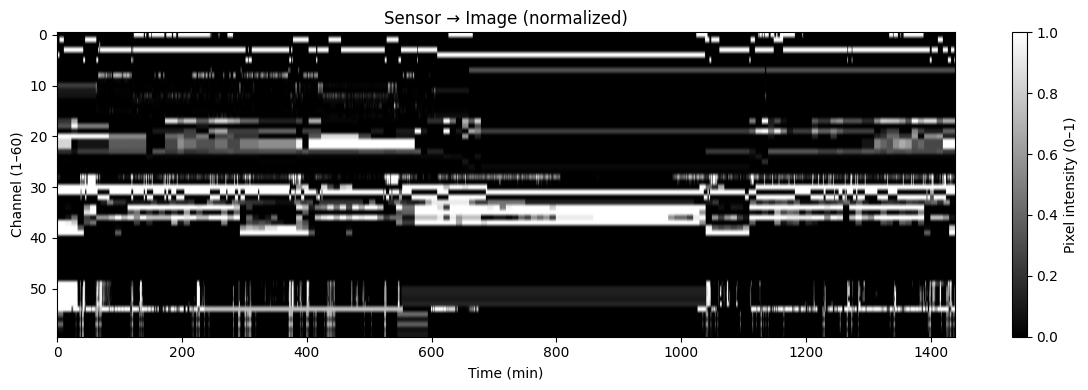

In [46]:
import matplotlib.pyplot as plt

# 첫 번째 샘플(0번)
img_tensor = X_tensor[0,0]     # shape = (60,1440), 값은 0~1

plt.figure(figsize=(12, 4))
plt.imshow(img_tensor.numpy(), aspect='auto', cmap='gray',
           vmin=0, vmax=1)         # 0~1 범위로 고정
plt.title('Sensor → Image (normalized)')
plt.xlabel('Time (min)')
plt.ylabel('Channel (1–60)')
plt.colorbar(label='Pixel intensity (0–1)')
plt.tight_layout()
plt.show()

# (1) 스택 & 채널×시간 형태로 변환

In [ ]:
# 1) NumPy → Tensor 전처리
# X_seq: 리스트 of (1440,60) → NumPy stack → (N,1440,60)
X = np.stack(X_seq)                # (N,1440,60)
X = X.transpose(0,2,1)            # (N,60,1440)
X_tensor = torch.from_numpy(X)    # (N,60,1440)
# CNN에 입력하려면 channel 차원(1) 추가
X_tensor = X_tensor.unsqueeze(1).float()  # (N,1,60,1440)

# y_target: (N,6)
y_tensor = torch.from_numpy(y_target).float()  # (N,6)

### 1 상관관계로 40개 피처만 남김 -> 50%

In [52]:
'''
# 1) NumPy → Tensor 전처리
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

# X_seq: 리스트 of (1440,60), y_target: (N,6)
N = len(X_seq)
T, C = X_seq[0].shape  # T=1440, C=60

# 1) NumPy 스택
X = np.stack(X_seq)    # (N,1440,60)

# ── A. 상관관계 기반 채널 선택 ───────────────────────
# 1-1) 하루 평균 기준 상관계수 계산
X_mean = X.mean(axis=1)         # (N,60)
corrs = np.zeros((C, y_target.shape[1]))
for j in range(C):
    for k in range(y_target.shape[1]):
        corrs[j,k] = pearsonr(X_mean[:,j], y_target[:,k])[0]
scores = np.abs(corrs).max(axis=1)        # 채널별 중요도 점수
ranked = np.argsort(scores)               # 낮은 순서 정렬

# 1-2) 하위 20개 제거
n_remove = 20
keep_idx = np.setdiff1d(np.arange(C), ranked[:n_remove])
# 1-3) 선택된 채널로 재구성
X_sel = X[:,:,keep_idx]                   # (N,1440, C-20)
in_ch_sel = X_sel.shape[2]

# ── Tensor 변환 ──────────────────────────────────
# A: 선택된 채널용
X_sel_t = torch.from_numpy(X_sel.transpose(0,2,1))  # (N, C-20, T)
X_sel_t = X_sel_t.unsqueeze(1).float()              # (N,1, C-20, T)

# y_target: (N,6)
y_tensor = torch.from_numpy(y_target).float()  # (N,6)

# 입력 텐서
X_tensor = X_sel_t   # shape = (N,1,40,1440)
in_ch = 1
H = 40
W = 1440

'''

### 2 pca 차원축소 - 51%

In [72]:
'''
# X_seq: 리스트 of (1440,60), y_target: (N,6)
N = len(X_seq)
T, C = X_seq[0].shape  # T=1440, C=60

# 1) NumPy 스택
X = np.stack(X_seq)    # (N,1440,60)

# ── B. PCA 기반 차원 축소 ─────────────────────────
# 1-1) Flatten → PCA
X_flat = X.reshape(-1, C)                 # (N*T,60)
pca    = PCA(n_components=30)
X_pca_flat = pca.fit_transform(X_flat)    # (N*T,30)
# 1-2) 다시 (N,1440,30)
X_pca = X_pca_flat.reshape(N, T, 30)
in_ch_pca = 30

# ── Tensor 변환 ──────────────────────────────────
# B: PCA 축소용
X_pca_t = torch.from_numpy(X_pca.transpose(0,2,1))  # (N,30, T)
X_pca_t = X_pca_t.unsqueeze(1).float()              # (N,1,30, T)

# y_target: (N,6)
y_tensor = torch.from_numpy(y_target).float()  # (N,6)


# 입력텐서
X_tensor = X_pca_t   # shape = (N,1,30,1440)
in_ch = 1
H = 30
W = 1440
'''

# (2) Dataset & DataLoader

In [75]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 8
ds     = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)

# 3) PixleepFlow (자동 feature‐map 크기 계산)

In [76]:
class PixleepFlowMultiHead(nn.Module):
    def __init__(self, in_ch=1, H=60, W=1440):
        super().__init__()
        # 2번 Conv→ReLU→Pool
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),     nn.ReLU(), nn.MaxPool2d(2),
        )
        feat_h, feat_w = H // 4, W // 4  # pooling 두 번
        flat_dim = 32 * feat_h * feat_w

        # Shared FC
        self.shared_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, 128),
            nn.ReLU(),
        )
        # Binary tasks: Q1,Q2,Q3,S2,S3 → 5 logits
        self.head_bin = nn.Linear(128, 5)
        # Multi-class task: S1 → 3 logits
        self.head_s1 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.features(x)      # → (B,32, feat_h, feat_w)
        x = self.shared_fc(x)     # → (B,128)
        return self.head_bin(x), self.head_s1(x)

# (4) 손실/옵티마이저

In [77]:
import torch.optim as optim

bce = nn.BCEWithLogitsLoss()   # binary
ce  = nn.CrossEntropyLoss()    # multi-class

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PixleepFlowMultiHead(in_ch=1, H=60, W=1440).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
print(in_ch);print(H)

# 5) 학습 루프 (10 epochs)

In [79]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        bin_logits, s1_logits = model(imgs)
        # binary labels: Q1,Q2,Q3 (0:3), S2,S3 (4,5)
        y_bin = torch.cat([labels[:, :3], labels[:, 4:6]], dim=1)  # (B,5)
        # multi-class label: S1
        y_s1 = labels[:, 3].long()  # (B,)

        # losses
        loss_bin = bce(bin_logits, y_bin)
        loss_s1 = ce(s1_logits, y_s1)
        loss = loss_bin + loss_s1

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg = total_loss / len(loader)
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {avg:.4f}")


Epoch 1/10 Loss: 2.4419
Epoch 2/10 Loss: 1.5992
Epoch 3/10 Loss: 1.3329
Epoch 4/10 Loss: 0.8851
Epoch 5/10 Loss: 0.5211
Epoch 6/10 Loss: 0.3018
Epoch 7/10 Loss: 0.1224
Epoch 8/10 Loss: 0.0573
Epoch 9/10 Loss: 0.0255
Epoch 10/10 Loss: 0.0116


In [80]:
torch.save(model.state_dict(), "pixleepflow_multih_head.pth")

# 6) ❗예시 예측 출력

In [84]:
model.eval()
with torch.no_grad():
    imgs, labels = next(iter(loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # 1) 로짓 추론
    bin_logits, s1_logits = model(imgs)   # shapes: (B,5), (B,3)

    # 2) 확률 변환
    bin_probs = torch.sigmoid(bin_logits)  # (B,5), 0~1
    # s1는 softmax → class 확률
    s1_probs = torch.softmax(s1_logits, dim=1)  # (B,3)

    # 3) 이진 예측 & 다중 클래스 예측
    bin_preds = (bin_probs >= 0.5).int()        # (B,5)
    s1_preds = torch.argmax(s1_probs, dim=1)   # (B,)

    # 4) 첫 번째 배치만 출력
    i = 5
    print(f"실제   → Q1–Q3,S1,S2,S3: {labels[i].cpu().numpy()}")
    print(f"모델출력 Binary logits (Q1,Q2,Q3,S2,S3): {bin_logits[i].cpu().numpy()}")
    print(f"확률 Binary probs  (Q1,Q2,Q3,S2,S3): {bin_probs[i].cpu().numpy()}")
    print(f"예측 Binary preds  (Q1,Q2,Q3,S2,S3): {bin_preds[i].cpu().numpy()}")
    print(f"모델출력 S1 logits  (3-class)         : {s1_logits[i].cpu().numpy()}")
    print(f"확률 S1 probs   (softmax, 3-class): {s1_probs[i].cpu().numpy()}")
    print(f"예측 S1 pred    (argmax class)    : {s1_preds[i].item()}")


실제   → Q1–Q3,S1,S2,S3: [0. 1. 1. 0. 0. 1.]
모델출력 Binary logits (Q1,Q2,Q3,S2,S3): [-6.378007   6.0096908  4.665032  -4.485591   6.0067697]
확률 Binary probs  (Q1,Q2,Q3,S2,S3): [0.00169562 0.99755114 0.99066895 0.01114462 0.997544  ]
예측 Binary preds  (Q1,Q2,Q3,S2,S3): [0 1 1 0 1]
모델출력 S1 logits  (3-class)         : [12.81033    3.4069862 -3.2163439]
확률 S1 probs   (softmax, 3-class): [9.9991739e-01 8.2441074e-05 1.0956401e-07]
예측 S1 pred    (argmax class)    : 0


# 제출 파일 생성

In [ ]:
# 0) sample_submission 불러오기
df_sub = pd.read_csv(
    "/content/drive/MyDrive/Sleep/ch2025_submission_sample.csv",
    parse_dates=['lifelog_date','sleep_date']
)

# 1) df_sub 순서대로 테스트 시퀀스 생성
X_test_seq = []
for _, row in df_sub.iterrows():
    arr = merge_input_timeseries(
        row['subject_id'],
        row['lifelog_date'],
        row['sleep_date'],
        input_dict
    ).values
    X_test_seq.append(arr)

# 2) NumPy stack & transpose → Tensor
X_test = np.stack(X_test_seq)         # (250,1440,60)
X_test = X_test.transpose(0,2,1)      # (250,60,1440)
X_test_tensor = torch.from_numpy(X_test).unsqueeze(1).float()
test_ds = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

# 가중치로드
model.load_state_dict(torch.load("pixleepflow_multih_head.pth", map_location=device))

# 3) 모델 추론 (멀티헤드)
model.eval()
model.to(device)

all_bin_logits = []
all_s1_logits  = []
with torch.no_grad():
    for (imgs,) in test_loader:
        imgs = imgs.to(device)
        bin_logits, s1_logits = model(imgs)       # (B,5), (B,3)
        all_bin_logits.append(bin_logits.cpu().numpy())
        all_s1_logits .append(s1_logits.cpu().numpy())

all_bin_logits = np.vstack(all_bin_logits)     # (250,5)
all_s1_logits  = np.vstack(all_s1_logits)      # (250,3)

# 4) 확률 변환 & 예측
bin_probs = 1 / (1 + np.exp(-all_bin_logits))  # sigmoid

df_sub['Q1'] = (bin_probs[:,0] >= 0.5).astype(int)
df_sub['Q2'] = (bin_probs[:,1] >= 0.5).astype(int)
df_sub['Q3'] = (bin_probs[:,2] >= 0.5).astype(int)

df_sub['S1'] = np.argmax(all_s1_logits, axis=1)

df_sub['S2'] = (bin_probs[:,3] >= 0.5).astype(int)
df_sub['S3'] = (bin_probs[:,4] >= 0.5).astype(int)

# 5) submission.csv 저장
out_path = "/content/drive/MyDrive/Sleep/submission_file/submission8.csv"
df_sub.to_csv(out_path, index=False)
print(f"▶ {out_path} 생성 완료")


In [70]:
df_sub.shape

(250, 9)